In [50]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
file_path = "/Users/bubble/Temp/ev0000364000.h5"

In [51]:
# Open the file
f = h5py.File(file_path, 'r')

In [52]:
print(f.attrs['mag'],
f.attrs['ele'],
f.attrs['lat'],
f.attrs['lon'],
f.attrs['time']
)

7.0 0.330 37.050000 142.320833 2014-07-11T19:22:00.440000Z


In [53]:
# List all the attributes for the file
list(f.attrs.keys())

['ele', 'lat', 'lon', 'mag', 'time']

In [54]:
# Extract a portion of the data from numerous stations

import numpy as np

# List of stations to consider
stations_list = ['IWEH', 'KI2H', 'MKJH', 'NMEH']

# Number of channels
num_channels = 3

# Allocate the space to save the extracted data
data = np.empty((len(stations_list),num_channels,24*3600*100))

for i in range(len(stations_list)):
    data[i,0:num_channels,:] = f[stations_list[i]][0:num_channels,-24*3600*100:]
    
print(data.shape)

(4, 3, 8640000)


In [55]:
fig,ax=plt.subplots(3,figsize=(10,9))
ax[0].plot(data[0,0,:],'k-')
ax[1].plot(data[0,1,:],'k-')
ax[2].plot(data[0,2,3:],'k-')

In [13]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork

%config InlineBackend.figure_format = "svg"

In [14]:
segment_duration_seconds = 20.0
sampling_rate_hertz = 50.0
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

In [15]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=1000, sampling_rate=50.0, len=2)
ComplexMorletBank(bins=1000, octaves=4, resolution=4, quality=1, sampling_rate=50.0, len=16)
ComplexMorletBank(bins=1000, octaves=5, resolution=2, quality=3, sampling_rate=50.0, len=10)


In [18]:
dirpath_save = "../example"

# Create directory to save the results
os.makedirs(dirpath_save, exist_ok=True)

# Save the scattering network with Pickle
filepath_save = os.path.join(dirpath_save, "scattering_network.pickle")
with open(filepath_save, "wb") as file_save:
    pickle.dump(network, file_save, protocol=pickle.HIGHEST_PROTOCOL)
    

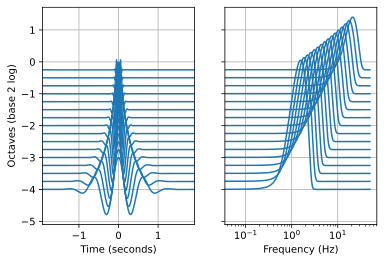

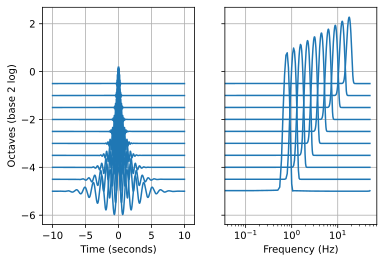

In [19]:
# Loop over network layers
for bank in network.banks:

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):

        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[0].grid()
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()

In [20]:
import pickle

import numpy as np
from matplotlib import dates as mdates
from matplotlib import pyplot as plt

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

In [2]:
network = pickle.load(open("../example/scattering_network.pickle", "rb"))

In [3]:
# Connect to the IRIS datacenter
client = Client("IRIS")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="YH",
    station="DC08",
    location="*",
    channel="*",
    starttime=UTCDateTime("2012-07-25T00:00"),
    endtime=UTCDateTime("2012-07-26T00:00"),
)

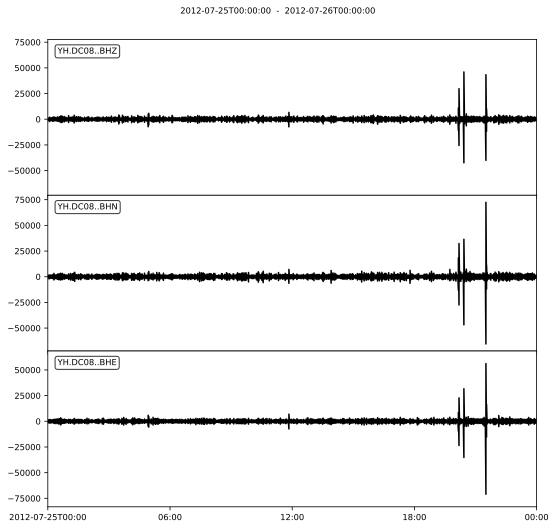

d:\Software\Anaconda3\lib\site-packages\obspy\io\mseed\core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [4]:
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)
stream.plot(rasterized=True);

stream.write("../example/scattering_stream.mseed", format="MSEED")

In [5]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

In [23]:
scattering_coefficients = network.transform(segments, reduce_type=np.max)

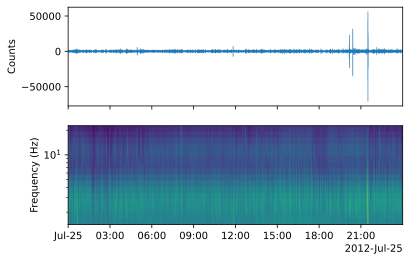

In [24]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=300)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")

# Show
plt.show()

In [25]:
np.savez(
    "../example/scattering_coefficients.npz",
    order_1=scattering_coefficients[0],
    order_2=scattering_coefficients[1],
    times=timestamps,
)

In [26]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

In [27]:
# Load data from file
with np.load("../example/scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 8639 samples of 528 dimensions each.


In [31]:
model = FastICA(n_components=10, whiten="unit-variance", random_state=42)
features = model.fit_transform(scattering_coefficients)

In [32]:
# Save the features
np.savez(
    "../example/independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open("../example/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )

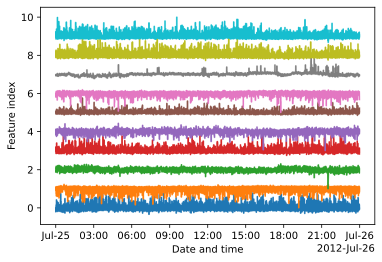

In [33]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=200)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

# Show
plt.show()

In [34]:
# Load the scattering network
network = pickle.load(open("../example/scattering_network.pickle", "rb"))

# Load the dimensionality reduction model
dimension_model = pickle.load(open("../example/dimension_model.pickle", "rb"))

# Load data from file
with np.load("../example/independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

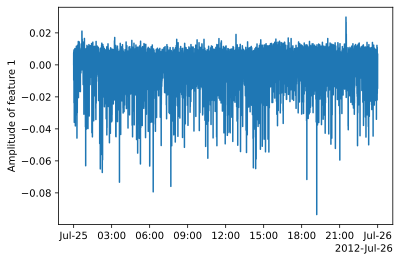

In [35]:
# Pick a feature
feature_id = 1
feature = features[:, feature_id]

# Figure creation
fig = plt.figure()
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

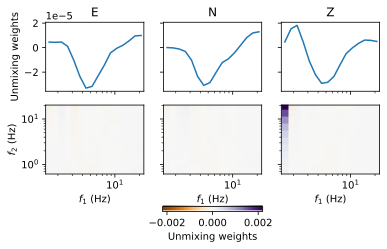

In [36]:
# Etract weights from the dimensionality reduction model
weights = dimension_model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row")
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("ENZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="horizontal", ax=ax, shrink=0.3)
colorbar.set_label("Unmixing weights")

# Show
plt.show()

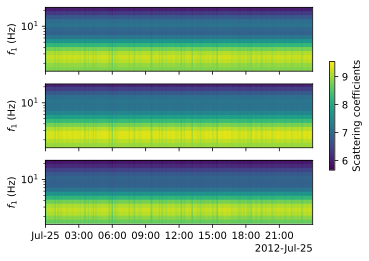

In [37]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = dimension_model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row")

# Plot
for id, channel in enumerate("ENZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")